<a href="https://colab.research.google.com/github/khataei/PE-classification-DeepLearning/blob/master/Tunned-Talos-1-CNN-activity-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Talos Tuner for CNN Activity Classifier

In this notebook, we use [Talos](https://github.com/autonomio/talos/blob/master/docs/Optimization_Strategies.md)  to tune a CNN neural net to classify PE activity.

#### Load dependencies

In [53]:
import os  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import AveragePooling1D, LeakyReLU , MaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import roc_auc_score, roc_curve 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17617742698806743389
]
# GPUs Available:  0


'1.14.0'

#### Set hyperparameters

In [2]:
# output directory name:
output_dir = 'model_output/cnn2'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency


In [56]:
# sklearn hyperparams
params = {
    'n_conv_1':[256, 512, 768], # filters, a.k.a. kernels
    'k_conv_1':[3, 5], # kernel length
    'n_conv_2':[256, 512, 768], # filters, a.k.a. kernels
    'k_conv_2':[3, 5], # kernel length
    'n_conv_3':[256, 512, 768], # filters, a.k.a. kernels
    'k_conv_3':[3, 5], # kernel length
    'maxpooling_pool_size':[2, 4],
    'avepooling_pool_size':[2, 4],
    'n_dense_1':[256, 512],
    'dropout_1':[0.2, 0.4],
    'n_dense_2':[256, 512],
    'dropout_2':[0.2, 0.4],
    'activation':['relu','elu']
}

# training:
epochs = 30
batch_size = 256


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [4]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [11]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']
input_shape = list(accel_array.shape)


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [6]:
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)

In [7]:
y = to_categorical(labels_array_int, num_classes=n_class)


### Splitting and shuffeling the data

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)


#### Design neural network architecture

In [57]:
params

{'n_conv_1': [256, 512, 768],
 'k_conv_1': [3, 5],
 'n_conv_2': [256, 512, 768],
 'k_conv_2': [3, 5],
 'n_conv_3': [256, 512, 768],
 'k_conv_3': [3, 5],
 'maxpooling_pool_size': [2, 4],
 'avepooling_pool_size': [2, 4],
 'n_dense_1': [256, 512],
 'dropout_1': [0.2, 0.4],
 'n_dense_2': [256, 512],
 'dropout_2': [0.2, 0.4],
 'activation': ['relu', 'elu']}

In [49]:
def create_model(n_conv_1=256, k_conv_1=3, n_conv_2=256, k_conv_2=3, n_conv_3=256, k_conv_3=3,
                 maxpooling_pool_size = 2, avepooling_pool_size = 2, n_dense_1=256, dropout_1=0.2,
                 n_dense_2=256, dropout_2=0.2, activation='elu'
                ):
    model = Sequential()
    model.add(Conv1D(n_conv_1, k_conv_1, activation, input_shape=input_shape[1:]))
    model.add(MaxPool1D(pool_size = maxpooling_pool_size))
    model.add(Conv1D(n_conv_2, k_conv_2, activation))
    model.add(AveragePooling1D(pool_size = avepooling_pool_size))
    model.add(Conv1D(n_conv_3, k_conv_3, activation))
    # model.add(GlobalMaxPooling1D())
    model.add(GlobalAveragePooling1D())
    model.add(Dense(n_dense_1, activation))
    model.add(Dropout(dropout_1))
    model.add(Dense(n_dense_2, activation))
    model.add(Dropout(dropout_2))
    model.add(Dense(n_class, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

    return model

Wall time: 0 ns


In [12]:
model_default = create_model()
model_default.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 256)           2560      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 42, 256)           196864    
_________________________________________________________________
average_pooling1d (AveragePo (None, 21, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 256)           131328    
_________________________________________________________________
global_average_pooling1d (Gl (None, 256)               0         
__

In [14]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size)

In [16]:
rscv = RandomizedSearchCV(model, param_distributions=params, cv=4, n_iter=20)
rscv_results = rscv.fit(X_train,y_train)

C:\Users\dfuller\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/4
38852/38852 [==============================] - 17s 436us/sample - loss: 1.1640 - acc: 0.5074
Epoch 2/4
38852/38852 [==============================] - 17s 436us/sample - loss: 0.8445 - acc: 0.6567
Epoch 3/4
38852/38852 [==============================] - 17s 430us/sample - loss: 0.6432 - acc: 0.7434
Epoch 4/4
19426/19426 [==============================] - 3s 136us/sample - loss: 0.3705 - acc: 0.8680
Epoch 1/4
38852/38852 [==============================] - 17s 446us/sample - loss: 1.1471 - acc: 0.5119
Epoch 2/4
38852/38852 [==============================] - 17s 436us/sample - loss: 0.8390 - acc: 0.6531
Epoch 3/4
38852/38852 [==============================] - 17s 435us/sample - loss: 0.6344 - acc: 0.7470
Epoch 4/4
19426/19426 [==============================] - 3s 155us/sample - loss: 0.4221 - acc: 0.8447
Epoch 1/4
38852/38852 [==============================] - 17s 435us/sample - loss: 1.1444 - acc: 0.5176
Epoch 2/4
38852/38852 [==============================] - 16s 414us/sample -

38852/38852 [==============================] - 67s 2ms/sample - loss: 0.8388 - acc: 0.6520
Epoch 3/4
38852/38852 [==============================] - 67s 2ms/sample - loss: 0.6443 - acc: 0.7459
Epoch 4/4
19426/19426 [==============================] - 8s 418us/sample - loss: 0.3988 - acc: 0.8481
Epoch 1/4
38852/38852 [==============================] - 68s 2ms/sample - loss: 1.1273 - acc: 0.5239
Epoch 2/4
38852/38852 [==============================] - 68s 2ms/sample - loss: 0.8422 - acc: 0.6545
Epoch 3/4
38852/38852 [==============================] - 67s 2ms/sample - loss: 0.6540 - acc: 0.7418
Epoch 4/4
19426/19426 [==============================] - 8s 420us/sample - loss: 0.4027 - acc: 0.8522
Epoch 1/4
38852/38852 [==============================] - 17s 438us/sample - loss: 1.1004 - acc: 0.5398
Epoch 2/4
38852/38852 [==============================] - 17s 429us/sample - loss: 0.8235 - acc: 0.6607
Epoch 3/4
38852/38852 [==============================] - 17s 431us/sample - loss: 0.6739 - acc:

In [17]:
print('Best score is: {} using {}'.format(rscv_results.best_score_,
rscv_results.best_params_))

Best score is: 0.8561034997304281 using {'n_conv_1': 256, 'k_conv_1': 3}


In [19]:
best_model = rscv_results.best_estimator_

### Test the best model based on the validation data

In [20]:
y_hat = best_model.predict(X_valid)

In [27]:
y_hat = to_categorical(y_hat)
y_hat[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

In [30]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

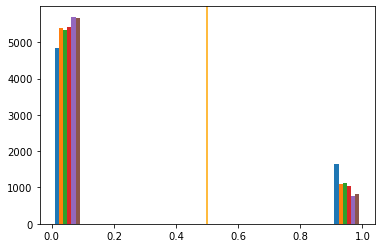

In [31]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [33]:
from sklearn.metrics import  accuracy_score as score
y_pred_classes = y_hat.round()
print(y_valid[0], y_hat[0], y_pred_classes[0])
acc = score(y_valid, y_pred_classes) * 100
acc

[0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.] [0. 0. 0. 0. 0. 1.]


88.40333539221741

In [34]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [35]:
"{:0.2f}".format(pct_auc)

'92.76'

In [36]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0:6].round(3))

In [37]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [38]:
ydf.head(10)

,y_hat,y
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
3,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
5,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
6,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
7,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"
8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
9,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]"


In [48]:
results_df = pd.DataFrame(rscv_results.cv_results_['params'])
results_df['mean'] = rscv_results.cv_results_['mean_test_score']
results_df['std'] = rscv_results.cv_results_['std_test_score']
results_df.sort_values('mean', ascending=False, ignore_index=False)

,n_conv_1,k_conv_1,mean,std
0,256,3,0.856103,0.009504
1,512,3,0.841175,0.006748
4,512,6,0.841038,0.016037
5,1024,6,0.834208,0.022568
8,1024,9,0.833145,0.015239
2,1024,3,0.831326,0.012370
6,256,9,0.826384,0.009073
7,512,9,0.808676,0.019014
3,256,6,0.785854,0.086530
